In [76]:
import pandas as pd
df = pd.read_csv('./train.csv')
print("\n\nMETADATA")
print("--------------------")

print(f"\n{len(df.index)} samples")
print(f"{len(df.columns)} columns")

print(f"\nnull count: \n{df.isnull().sum()}")

class_values = df.label.unique()
class_values.sort()
print(f"\nclasses:\n{class_values}")
print(df['label'].value_counts())


sum = 0
avg = 0
for i in class_values:
    sum+=len(df[df['label'] == i].index)
avg = sum/len(class_values)
print(f"\nAverage class distribution: {avg}")

class_distribution = df.groupby("label").size()
print(f"\nclass distribution:\n{class_distribution}")


print(df.head())




METADATA
--------------------

50000 samples
2 columns

null count: 
im_name    0
label      0
dtype: int64

classes:
[0 1 2 3 4 5 6 7 8 9]
label
2    5038
8    5020
1    5012
0    5010
3    5007
7    5000
4    4995
5    4993
9    4970
6    4955
Name: count, dtype: int64

Average class distribution: 5000.0

class distribution:
label
0    5010
1    5012
2    5038
3    5007
4    4995
5    4993
6    4955
7    5000
8    5020
9    4970
dtype: int64
       im_name  label
0  00016cd.jpg      6
1  0001808.jpg      2
2  0002399.jpg      1
3  0003973.jpg      3
4  00061cc.jpg      4


Comments on dataframe:

- The dataset is considered a large dataset. 50,000 samples is a lot.
- the dataset is clean. No need to interpolate missing values or remove columns/rows.
- the class distribution is very even. 
- there are 10 labels. Multiclass.


In [77]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import numpy as np
import math 

mpl.rcParams["figure.dpi"] = 150

first_sample = df.iloc[[0]]
print(f"FIRST SAMPLE:\n{first_sample}")
sample_image_name = first_sample.im_name.values[0]
image_path = f"./train_ims/{sample_image_name}"
im = Image.open(image_path)
pixels = np.array(list(im.getdata()))
im.close()
height = int(math.pow(len(pixels), 1/2))
width = height
print(f"\n\ndata dimension:\nheight: {int(height)}\nwidth: {int(width)}\nfeatures: {len(pixels)}\n\n")
print(pixels)



FIRST SAMPLE:
       im_name  label
0  00016cd.jpg      6


data dimension:
height: 32
width: 32
features: 1024


[[237 242 246]
 [238 246 249]
 [228 239 241]
 ...
 [112 150 153]
 [104 144 135]
 [ 96 139 122]]


Comments on data:
- number of features is very large.
- each feature has a RGB value. How do we convert RGB into a single value?
- can't split image into 3 colour groups, R, G, B. The relationships between different colours would be lost.
- images of the same class vary a lot. High variance within image classes.
- for instance, different angles, different colours, different distances from camera.



Initial Ideas:

Large dataset.
-> use smaller K in K-fold validation to improve training performance. 
-> Perhaps k = 5

Even class distribution:
-> no need to apply any class balancing techniques, such as penalty weighting.

Multiclass:
-> will need an ensemble of SVMs. A SVM for each class in a ensemble.

Features:
-> should NOT use feature selection. Features are heavily related to one another and the variance in images is too great.
-> feature reduction may be an idea, but the images are already so low resolution. Further compressing them may cause it to lose detail



model ideas:

- use an ensemble of HOG and colour SVMS
- OVA SVMS for each class.
- 10 grayscale HOG SVM classifers to determine a class based on image structure
- 10 colour SVM classifiers to determin a class based on colour structure
- together in one Ensemble

- augmentation ideas
- https://datamonje.com/image-data-augmentation/
- before any model training. pre-pre-procession.
- create the augmented images and name tham systematically. Put them in a different folder
- make a horiziontal flip image, a lighting transforms (randomised hue, saturation, contrast values) image, and a shear (stretch persepctive, etc)
- after all of this, duplicate everything and grayscale it.

- in end
- train_img (unaffected)
- train_GS_img
- train_aug_img
- train_GS_aus_img

come up with some naming system

BUILD A AUGMENTATION PIPELINE, copy something from internet.


- using data
- only use augmented data in training set. NOT IN VALIDATION OR TEST
- how?
- when training and going through each image name, load the augmented images by modifying the image name.
- i.e. img1234.jpg -> img1234_flip.jpg
- do a grid search to systemtically get all augmentations of that image.

- use nested-kfold.
- make sure only the inner trianing data uses augmented data.




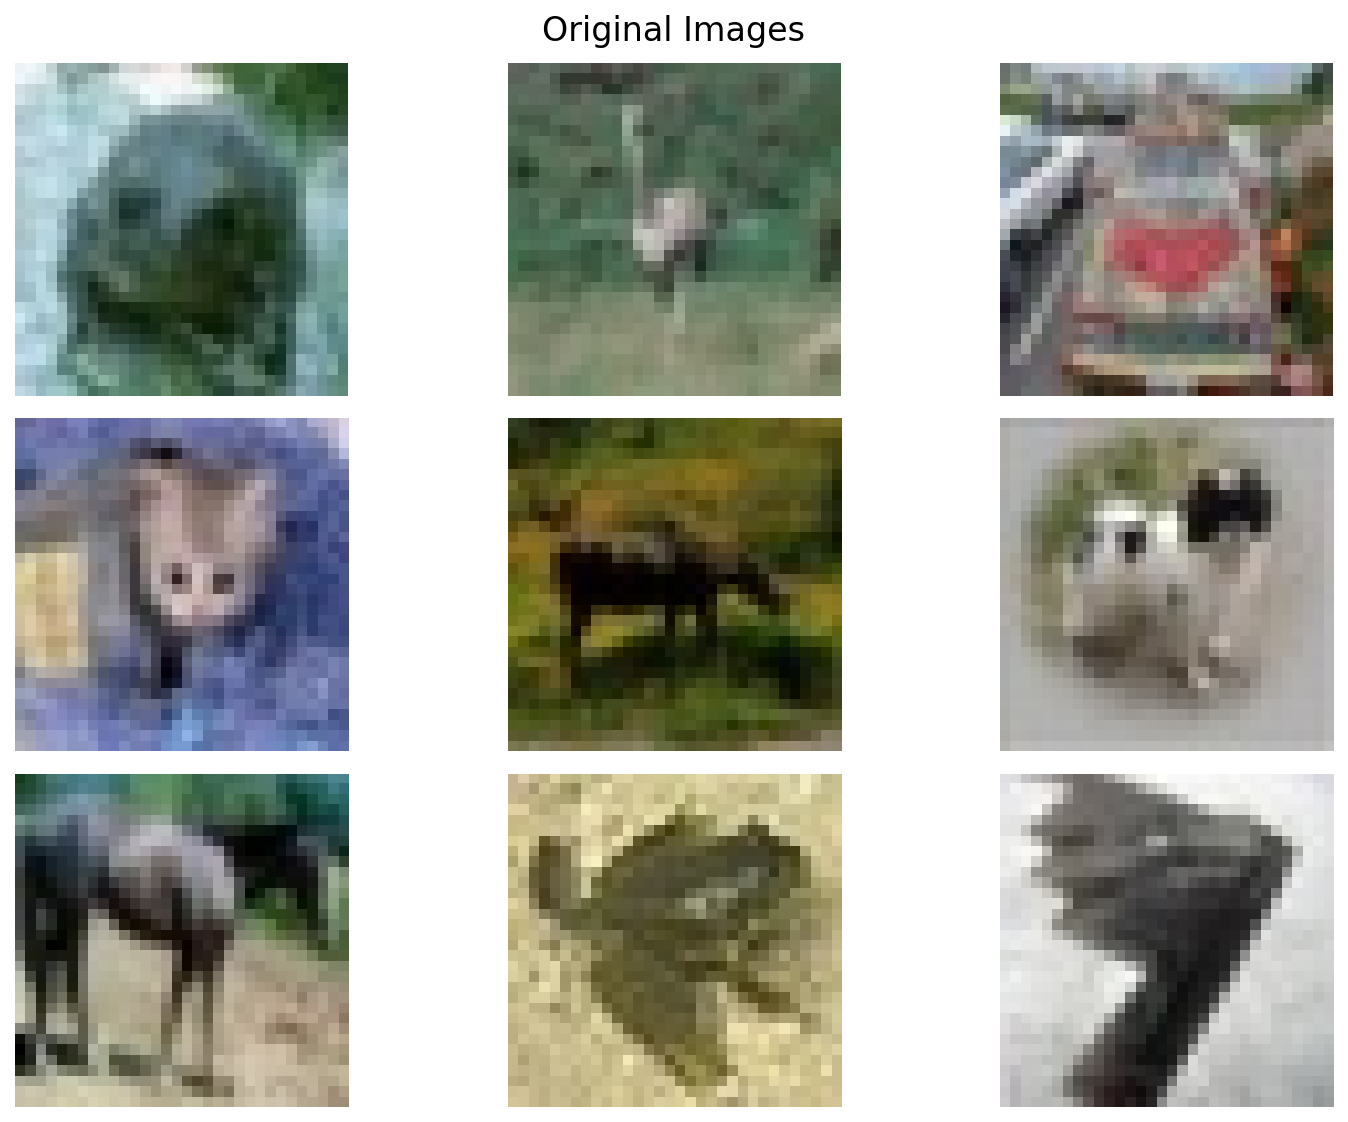

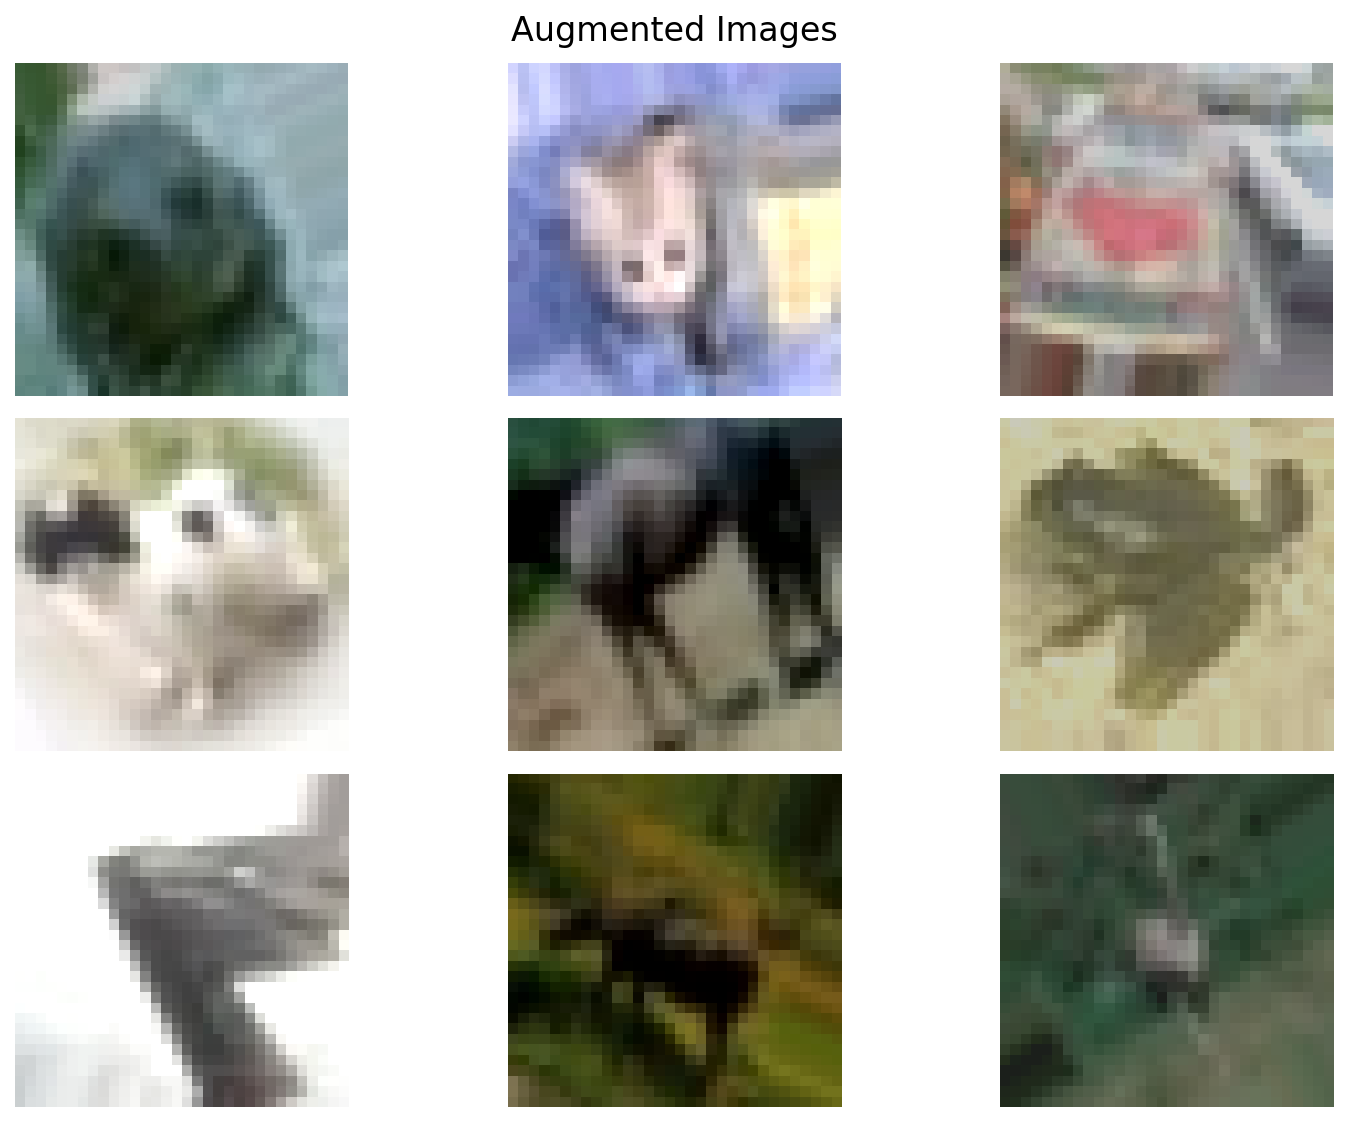

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt

def flip(image):
    return image[:, ::-1, :]  # Flip horizontally

# Function to display images
def display_images(images, cols=3, title="Images"):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    for i in range(len(images)):
        plt.subplot(len(images) // cols + 1, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')  # Hide axes
    plt.tight_layout()
    plt.show()

images = []
i = 0
for index, row in df.iterrows():
    path=f"train_ims/{row['im_name']}"
    im = Image.open(path)
    pixels = np.array(im) 
    images.append(pixels)
    im.close()
    i+=1
    if i == 9:
        break

untouched_data = np.array(images)
flipped_images = list(map(flip, images))
data=np.array(flipped_images)
# Normalize the pixel values to [0, 1]

# Create an instance of ImageDataGenerator for augmentation

datagen = ImageDataGenerator(
    rotation_range=30,              # Slight rotation to avoid losing too much information
    width_shift_range=0.1,          # 10% shift is reasonable for small images
    height_shift_range=0.1,         # 10% shift
    shear_range=0.25,                # Moderate shear
    zoom_range=0.05,                 # Up to 10% zoom
    horizontal_flip=False,           # Enable horizontal flipping for diversity
    vertical_flip=False,            # Typically not needed for 32x32 images
    rescale=1/255,                  # Normalize pixel values
    brightness_range=[0.8, 1.2],    # Slight brightness adjustment
    fill_mode='nearest',            # Fill in new pixels after transformations
    channel_shift_range=50          # Color jittering (shift channels)
)

# Fit the generator on the data
datagen.fit(data)

# Display original images
display_images(untouched_data[:9], cols=3, title="Original Images")

# Generate a batch of augmented images
augmented_images = next(datagen.flow(data, batch_size=9))  # Get a batch of 9 images

# Display the augmented images
display_images(augmented_images, cols=3, title="Augmented Images")